# Load Minimum Wage Data
Minimal notebook to load and inspect the dataset.

In [23]:
import pandas as pd

In [24]:
df = pd.read_csv("data/min_wage_CS.csv")
df.head()

,state_name,county_name,emp0A01_BS,year,quarter,countyreal,censusdiv,FIPS,msa,pop,...,col,medinc,pov,nssi,first.treat,treat,lemp,lpop,lmedinc,region
0,Colorado,Adams,6190,2001,1,8001,8,8001,True,363.857,...,0.13,40.802,0.104,5009,2007,1,8.730690,5.896761,3.708731,4
1,Colorado,Adams,5122,2002,1,8001,8,8001,True,363.857,...,0.13,40.802,0.104,5009,2007,1,8.541300,5.896761,3.708731,4
2,Colorado,Adams,4729,2003,1,8001,8,8001,True,363.857,...,0.13,40.802,0.104,5009,2007,1,8.461469,5.896761,3.708731,4
3,Colorado,Adams,4175,2004,1,8001,8,8001,True,363.857,...,0.13,40.802,0.104,5009,2007,1,8.336870,5.896761,3.708731,4
4,Colorado,Adams,4189,2005,1,8001,8,8001,True,363.857,...,0.13,40.802,0.104,5009,2007,1,8.340217,5.896761,3.708731,4


In [25]:
# Summary statistics for all columns
summary = df.describe(include='all')
summary

,state_name,county_name,emp0A01_BS,year,quarter,countyreal,censusdiv,FIPS,msa,pop,...,col,medinc,pov,nssi,first.treat,treat,lemp,lpop,lmedinc,region
count,15988,15988,15988.000000,15988.000000,15988.0,15988.000000,15988.000000,15988.000000,15988,15988.000000,...,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000
unique,29,1436,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Texas,Washington,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1722,140,NaN,NaN,NaN,NaN,NaN,NaN,15988,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1086.871216,2004.000000,1.0,32429.324431,5.047723,32429.324431,NaN,69.665551,...,0.132139,32.692698,0.146979,1396.727233,796.771454,0.397110,5.714803,3.224796,3.461655,2.660245
std,NaN,NaN,3162.274147,2.000063,0.0,14042.173368,1.613506,14042.173368,NaN,200.788033,...,0.063424,7.732934,0.061262,4806.914870,981.772258,0.489315,1.525451,1.304159,0.222601,0.649131
min,NaN,NaN,3.000000,2001.000000,1.0,8001.000000,3.000000,8001.000000,NaN,0.729000,...,0.037000,14.178000,0.019000,0.000000,0.000000,0.000000,1.098612,-0.316082,2.651691,2.000000
25%,NaN,NaN,112.000000,2002.000000,1.0,19120.500000,4.000000,19120.500000,NaN,10.586500,...,0.092000,27.591750,0.105000,191.750000,0.000000,0.000000,4.718499,2.359579,3.317517,2.000000
50%,NaN,NaN,287.000000,2004.000000,1.0,31034.000000,5.000000,31034.000000,NaN,22.900500,...,0.116000,31.493000,0.136000,476.500000,0.000000,0.000000,5.659482,3.131159,3.449765,3.000000
75%,NaN,NaN,752.000000,2006.000000,1.0,47107.500000,7.000000,47107.500000,NaN,52.561750,...,0.150000,36.297250,0.181000,1141.000000,2007.000000,1.000000,6.622736,3.961988,3.591742,3.000000


In [26]:
# Group summary statistics: treated vs untreated
# Correct treated variable: True if first.treat > 0 (treated), False if first.treat == 0 (never-treated)
df['treated'] = df['first.treat'] > 0
group_stats = df.groupby('treated').agg({
    'region': 'mean',
    'pop': 'mean',
    'white': 'mean',
    'hs': 'mean',
    'pov': 'mean',
    'medinc': 'mean'
})
group_stats

,region,pop,white,hs,pov,medinc
treated,,,,,,
False,2.736383,53.425333,0.826348,0.553164,0.157271,31.888969
True,2.544653,94.321319,0.893352,0.585906,0.131353,33.912914


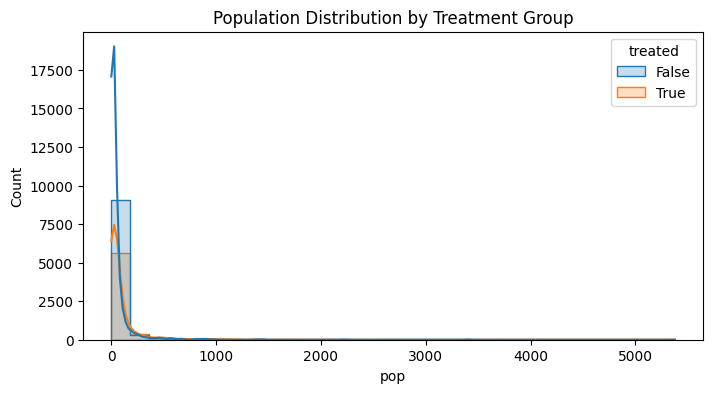

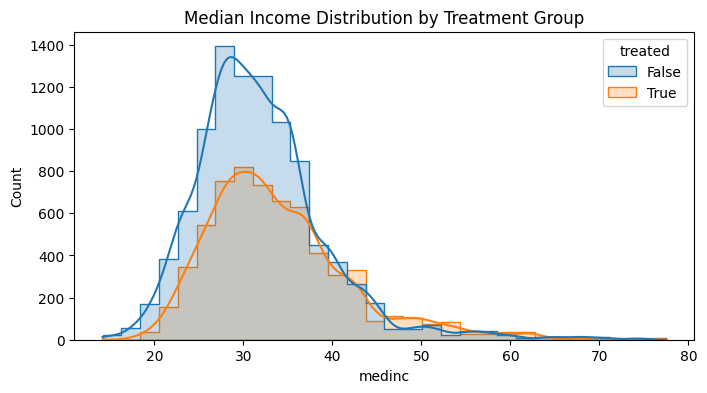

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize population distribution by treatment group
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='pop', hue='treated', bins=30, kde=True, element='step')
plt.title('Population Distribution by Treatment Group')
plt.show()

# Visualize median income by treatment group
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='medinc', hue='treated', bins=30, kde=True, element='step')
plt.title('Median Income Distribution by Treatment Group')
plt.show()

In [28]:
# Covariate construction
# region, medinc, pop, pop^2, medinc^2, white, hs, pov
df['region_name'] = df['region'].astype(str).map({'1': 'Northeast', '2': 'Midwest', '3': 'South', '4': 'West'})
df['pop2'] = df['pop'] ** 2
df['medinc2'] = df['medinc'] ** 2
df[['region', 'region_name', 'medinc', 'pop', 'pop2', 'medinc2', 'white', 'hs', 'pov']].head()

,region,region_name,medinc,pop,pop2,medinc2,white,hs,pov
0,4,West,40.802,363.857,132391.916449,1664.803204,0.773,0.658,0.104
1,4,West,40.802,363.857,132391.916449,1664.803204,0.773,0.658,0.104
2,4,West,40.802,363.857,132391.916449,1664.803204,0.773,0.658,0.104
3,4,West,40.802,363.857,132391.916449,1664.803204,0.773,0.658,0.104
4,4,West,40.802,363.857,132391.916449,1664.803204,0.773,0.658,0.104


## Detailed Summary Statistics by Treatment Group
Compare means and standard deviations for key variables, and compute t-tests for differences.

In [29]:
import pandas as pd
from scipy import stats
region_names = ['Midwest', 'South', 'West']
region_rows = []
for region in region_names:
    treated_share = (df[df['treated']]['region_name'] == region).mean()
    untreated_share = (df[~df['treated']]['region_name'] == region).mean()
    diff = treated_share - untreated_share
    n1 = df['treated'].sum()
    n2 = (~df['treated']).sum()
    count1 = (df[df['treated']]['region_name'] == region).sum()
    count2 = (df[~df['treated']]['region_name'] == region).sum()
    p = (count1 + count2) / (n1 + n2)
    se = (p * (1 - p) * (1/n1 + 1/n2)) ** 0.5
    z = diff / se if se > 0 else 0
    from scipy.stats import norm
    pval = 2 * (1 - norm.cdf(abs(z)))
    region_rows.append({
        'Variable': region,
        'Treated Mean': round(treated_share, 2),
        'Untreated Mean': round(untreated_share, 2),
        'Diff': round(diff, 2),
        'P-value': round(pval, 2)
    })
covariates = [
    ('Population (1000s)', 'pop'),
    ('White', 'white'),
    ('HS Graduates', 'hs'),
    ('Poverty Rate', 'pov'),
    ('Median Inc. (1000s)', 'medinc')
]
cov_rows = []
for label, var in covariates:
    treated = df[df['treated']][var]
    untreated = df[~df['treated']][var]
    tstat, pval = stats.ttest_ind(treated, untreated, nan_policy='omit', equal_var=False)
    cov_rows.append({
        'Variable': label,
        'Treated Mean': round(treated.mean(), 2),
        'Untreated Mean': round(untreated.mean(), 2),
        'Diff': round(treated.mean() - untreated.mean(), 2),
        'P-value': round(pval, 2)
    })
summary_df = pd.DataFrame(region_rows + cov_rows)
display(summary_df)

,Variable,Treated Mean,Untreated Mean,Diff,P-value
0,Midwest,0.59,0.34,0.26,0.0
1,South,0.27,0.59,-0.33,0.0
2,West,0.14,0.07,0.07,0.0
3,Population (1000s),94.32,53.43,40.90,0.0
4,White,0.89,0.83,0.07,0.0
5,HS Graduates,0.59,0.55,0.03,0.0
6,Poverty Rate,0.13,0.16,-0.03,0.0
7,Median Inc. (1000s),33.91,31.89,2.02,0.0


In [34]:
# Minimal Callaway & Sant'Anna DiD using csdid (Python)
# Install csdid if not already installed
try:
    from csdid.att_gt import ATTgt
except ImportError:
    import sys
    !{sys.executable} -m pip install csdid
    from csdid.att_gt import ATTgt

# Prepare data for csdid
covariates = ['region', 'medinc', 'pop', 'pop2', 'medinc2', 'white', 'hs', 'pov']

# Years and groups of interest
years = list(range(2002, 2008))
groups = [2004, 2006, 2007]

# Unconditional (no covariates)
attgt_uncond = ATTgt(
    yname='lemp',
    gname='first.treat',
    idname='countyreal',
    tname='year',
    xformla='~ 1',
    data=df
).fit(est_method='dr')

# Conditional (with covariates)
attgt_cond = ATTgt(
    yname='lemp',
    gname='first.treat',
    idname='countyreal',
    tname='year',
    xformla='~ ' + ' + '.join(covariates),
    data=df
).fit(est_method='dr')

# Helper to extract ATT for each group and year
def extract_att(attgt, groups, years):
    res = attgt.summ_attgt().summary2
    table = pd.DataFrame(index=groups, columns=years)
    for g in groups:
        for t in years:
            val = res.loc[(res['Group']==g) & (res['Time']==t), 'ATT(g, t)']
            table.loc[g, t] = val.values[0] if not val.empty else None
    return table

# Build tables
table_uncond = extract_att(attgt_uncond, groups, years)
table_cond = extract_att(attgt_cond, groups, years)

# Combine into one table with multiindex
table_uncond.index = pd.MultiIndex.from_product([['Unconditional'], table_uncond.index], names=['Trend','Group'])
table_cond.index = pd.MultiIndex.from_product([['Conditional'], table_cond.index], names=['Trend','Group'])
final_table = pd.concat([table_uncond, table_cond])
final_table.columns.name = 'Year'
display(final_table)

    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                        ^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                        ^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                        ^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                        ^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                        ^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                        ^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                        ^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                        ^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                        ^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                        ^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                

Year                   2002    2003    2004    2005    2006    2007
Trend         Group                                                
Unconditional 2004   0.0143  0.0189 -0.0339 -0.0705 -0.1253 -0.1356
              2006  -0.0333  0.0475  0.0165  0.0177 -0.0233 -0.0714
              2007  -0.0232  0.0175  0.0163  -0.001 -0.0391 -0.0276
Conditional   2004   0.0143  0.0189 -0.0339 -0.0705 -0.1253 -0.1356
              2006  -0.0333  0.0475  0.0165  0.0177 -0.0233 -0.0714
              2007  -0.0232  0.0175  0.0163  -0.001 -0.0391 -0.0276

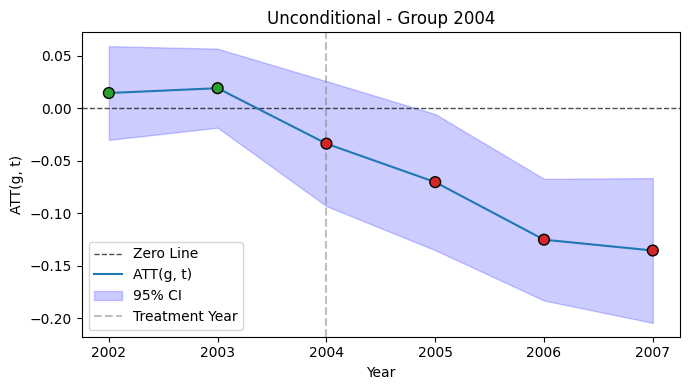

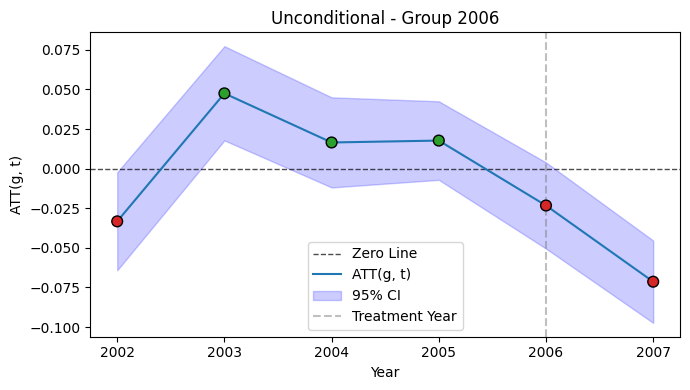

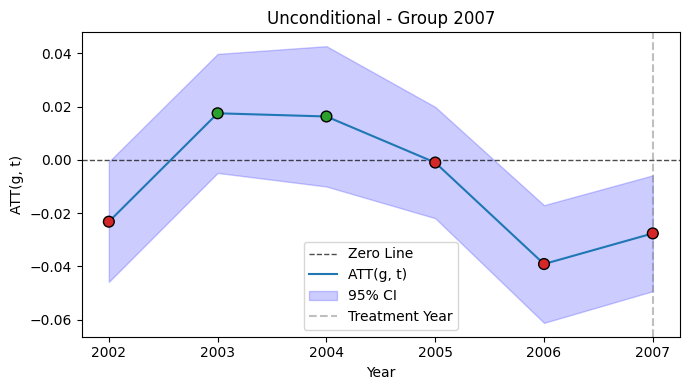

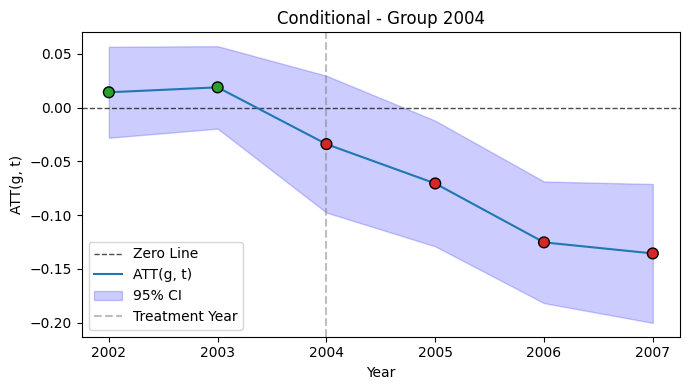

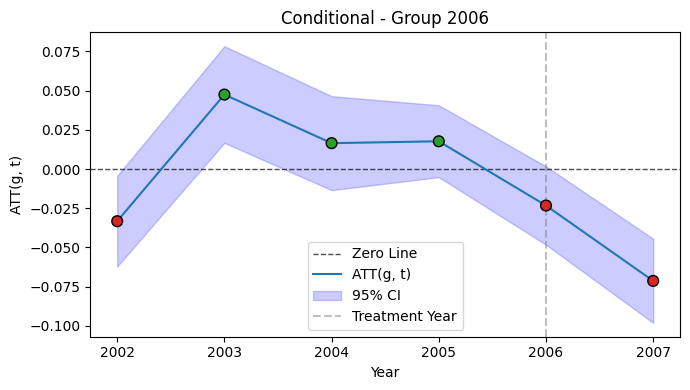

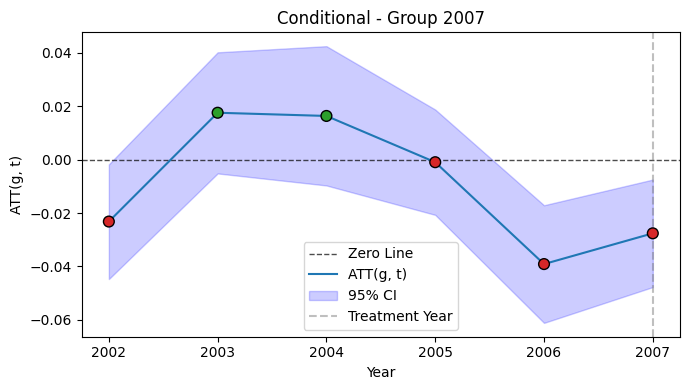

In [41]:
# Display 6 distinct plots: ATT(g, t) with 95% CI for each group and trend type
import matplotlib.pyplot as plt
import numpy as np

trend_types = ['Unconditional', 'Conditional']
groups = [2004, 2006, 2007]
years = list(range(2002, 2008))

for trend, attgt in zip(trend_types, [attgt_uncond, attgt_cond]):
    res = attgt.summ_attgt().summary2
    for group in groups:
        fig, ax = plt.subplots(figsize=(7, 4))
        att = []
        lower = []
        upper = []
        for t in years:
            row = res[(res['Group'] == group) & (res['Time'] == t)]
            if not row.empty:
                att.append(row['ATT(g, t)'].values[0])
                lower.append(row['[95% Pointwise'].values[0])
                upper.append(row['Conf. Band]'].values[0])
            else:
                att.append(np.nan)
                lower.append(np.nan)
                upper.append(np.nan)
        att = np.array(att, dtype=float)
        lower = np.array(lower, dtype=float)
        upper = np.array(upper, dtype=float)
        # Color points by sign
        colors = np.where(att >= 0, 'tab:green', 'tab:red')
        ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7, label='Zero Line')
        ax.plot(years, att, color='tab:blue', label='ATT(g, t)')
        ax.scatter(years, att, c=colors, s=60, zorder=3, edgecolor='k')
        ax.fill_between(years, lower, upper, color='b', alpha=0.2, label='95% CI')
        ax.axvline(x=group, color='gray', linestyle='--', alpha=0.5, label='Treatment Year')
        ax.set_title(f'{trend} - Group {group}')
        ax.set_xlabel('Year')
        ax.set_ylabel('ATT(g, t)')
        ax.legend()
        plt.tight_layout()
        plt.show()


In [42]:
# Install drdid if not already installed
%pip install drdid
import drdid

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
